# PLODI Unsupervised Models Working Notebook

Initial EDA was performed on the data sets by utilizing unsupervised models. Here we provide representative examples of various models and methods used throughout the capstone to initially interrogate and investigate the data prior to adopting semi-supervised and supervised models.

# Notebook Setup

In [2]:
import os
import re
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import seaborn as sns
# from sklearn.utils import resample
# from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
# from sklearn import svm
# from xgboost import plot_tree
# from xgboost import plot_importance
# from xgboost import XGBClassifier
# import xgboost as xgb
# from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
%matplotlib inline

In [3]:
%pip install pyod
from pyod.models.copod import COPOD

## Notebook Functions / Variables

In [4]:
random_state = 21
contamination = 0.08 # Identified target ranking outlier rate based lit review
n_jobs = -1 # Value for models to use multiple cores

## Connecting Google Drive for data storage


In [5]:
# Mount Google Drive and confirm access permissions to permitaccess for data located on Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Specify project directory personal filepaths under Google Drive
user_proj_path = ''

proj_dir = '/content/drive/MyDrive/' + user_proj_path + 'plodi/'
proj_dir_data_raw = proj_dir + 'data/raw/'
proj_dir_data_proc = proj_dir + 'data/processed/'

dirs = [proj_dir, proj_dir_data_raw, proj_dir_data_proc]

for dir in dirs:
    print('-----------------------------------------------------------------------')
    print('Directory contents for ', dir)
    %ls {dir}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
-----------------------------------------------------------------------
Directory contents for  /content/drive/MyDrive/plodi/
data/  notebooks/
-----------------------------------------------------------------------
Directory contents for  /content/drive/MyDrive/plodi/data/raw/
2-6%20digit_2017_Codes.xlsx      public_up_to_150k_11_230630.csv  public_up_to_150k_6_230630.csv
2-6%20digit_2022_Codes.xlsx      public_up_to_150k_12_230630.csv  public_up_to_150k_7_230630.csv
6-digit_2017_Codes.xlsx          public_up_to_150k_1_230630.csv   public_up_to_150k_8_230630.csv
6-digit_2022_Codes.xlsx          public_up_to_150k_2_230630.csv   public_up_to_150k_9_230630.csv
ppp-data-dictionary.xlsx         public_up_to_150k_3_230630.csv   sba_ppp_combined.csv
public_150k_plus_230630.csv      public_up_to_150k_4_230630.csv   sba_ppp_merged.csv
public_up_to_150k_10_230630.csv 

In [5]:
# drive.mount("/content/drive", force_remount=True) # Run if the Google drive needs to be remounted

# Run after completing Notebook run to gracefully disconnect Gdrive
# drive.flush_and_unmount()

Mounted at /content/drive


##System Specification Information

In [1]:
# Check instance specs
!df -h
!cat /proc/cpuinfo
!cat /proc/meminfo

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Filesystem      Size  Used Avail Use% Mounted on
overlay         226G   29G  198G  13% /
tmpfs            64M     0   64M   0% /dev
shm              25G     0   25G   0% /dev/shm
/dev/root       2.0G  1.1G  849M  57% /usr/sbin/docker-init
tmpfs            26G  6.1M   26G   1% /var/colab
/dev/sda1       233G   30G  203G  13% /etc/hosts
tmpfs            26G     0   26G   0% /proc/acpi
tmpfs            26G     0   26G   0% /proc/scsi
tmpfs            26G     0   26G   0% /sys/firmware
drive           104G   69G   36G  66% /content/drive
processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0xffffffff
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 8
core id		: 0
cpu cores	: 4
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdp

# Load Preprocessed Data and Model Downsampled Test / Train Data

In [6]:
# Read in the full modeling data and downsampled train/test data
index_col = 'LoanNumber'

df_model_data = pd.read_csv(proj_dir_data_proc+'modelling_data_cat_preproc.csv', header=0, index_col=index_col)
X_train = pd.read_csv(proj_dir_data_proc+'x_train.csv', header=0, index_col=index_col)
X_test = pd.read_csv(proj_dir_data_proc+'x_test.csv', header=0, index_col=index_col)
y_train = pd.read_csv(proj_dir_data_proc+'y_train.csv', header=0, index_col=index_col)
y_test = pd.read_csv(proj_dir_data_proc+'y_test.csv', header=0, index_col=index_col)

# Unsupervised Models

## PCA Visualization

In [25]:
# Apply PCA
pca = PCA(n_components=2)
loan_pca = pca.fit_transform(df_model_data)

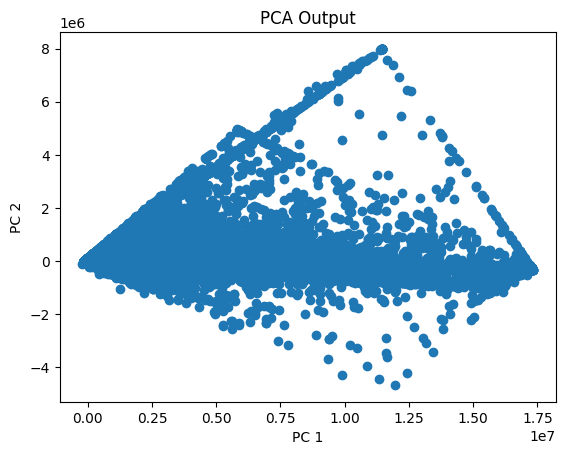

In [26]:
# Visualize PCA output
plt.scatter(loan_pca[:,0], loan_pca[:,1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA Output')
plt.show()

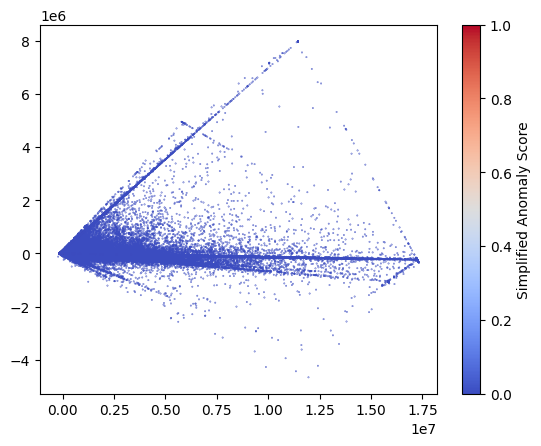

In [27]:
plt.scatter(loan_pca[:, 0], loan_pca[:, 1], c=df_model_data['CaseLabel_cat'], s=0.1, cmap='coolwarm')
plt.colorbar(label='Simplified Anomaly Score')
plt.show()

# t-SNE Dimensionality Reduction and IsolationForest

In [15]:
# Apply t-SNE
tsne = TSNE(n_components=2, n_jobs = -1)
loan_tsne = tsne.fit_transform(X_train)

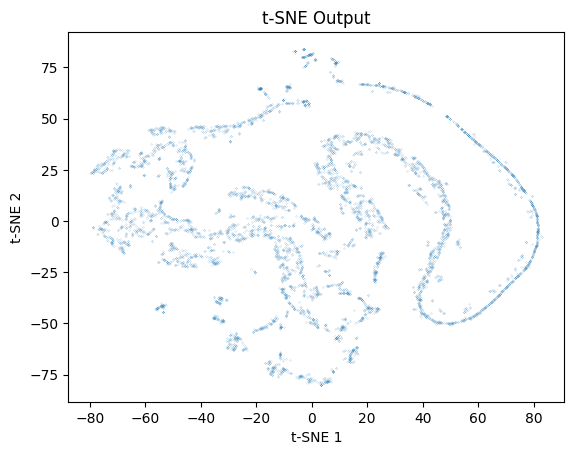

In [16]:
# Visualize t-SNE output
plt.scatter(loan_tsne[:,0], loan_tsne[:,1], s=0.01)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE Output')
plt.show()

In [17]:
i_forest_tsne = IsolationForest(n_estimators=200, contamination=contamination, verbose=2, n_jobs=-1)
i_forest_tsne.fit(loan_tsne)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Building estimator 1 of 25 for this parallel run (total 200)...Building estimator 1 of 25 for this parallel run (total 200)...
Building estimator 1 of 25 for this parallel run (total 200)...

Building estimator 2 of 25 for this parallel run (total 200)...
Building estimator 3 of 25 for this parallel run (total 200)...
Building estimator 1 of 25 for this parallel run (total 200)...Building estimator 1 of 25 for this parallel run (total 200)...
Building estimator 1 of 25 for this parallel run (total 200)...
Building estimator 1 of 25 for this parallel run (total 200)...
Building estimator 1 of 25 for this parallel run (total 200)...

Building estimator 4 of 25 for this parallel run (total 200)...
Building estimator 2 of 25 for this parallel run (total 200)...
Building estimator 2 of 25 for this parallel run (total 200)...
Building estimator 5 of 25 for this parallel run (total 200)...
Building estimator 6 of 25 for this parallel run (total 200)...
Building estimator 3 of 25 for this para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.6s remaining:    0.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.6s finished


IsolationForest(contamination=0.08, n_estimators=200, n_jobs=-1, verbose=2)

In [19]:
pred_iforest_tsne = i_forest_tsne.predict(loan_tsne)

Text(0.5, 0.01, 'Figure: t-SNE dimensionality reduction of sub-sampled (~1%) primary loan data set including 24 borrower and loan features excluding address and loan servicing features. IsolationForest model with unsupervised learning setting an anomaly (contamination) rate of 8% based on varying estimates of potential fraudulent loans.')

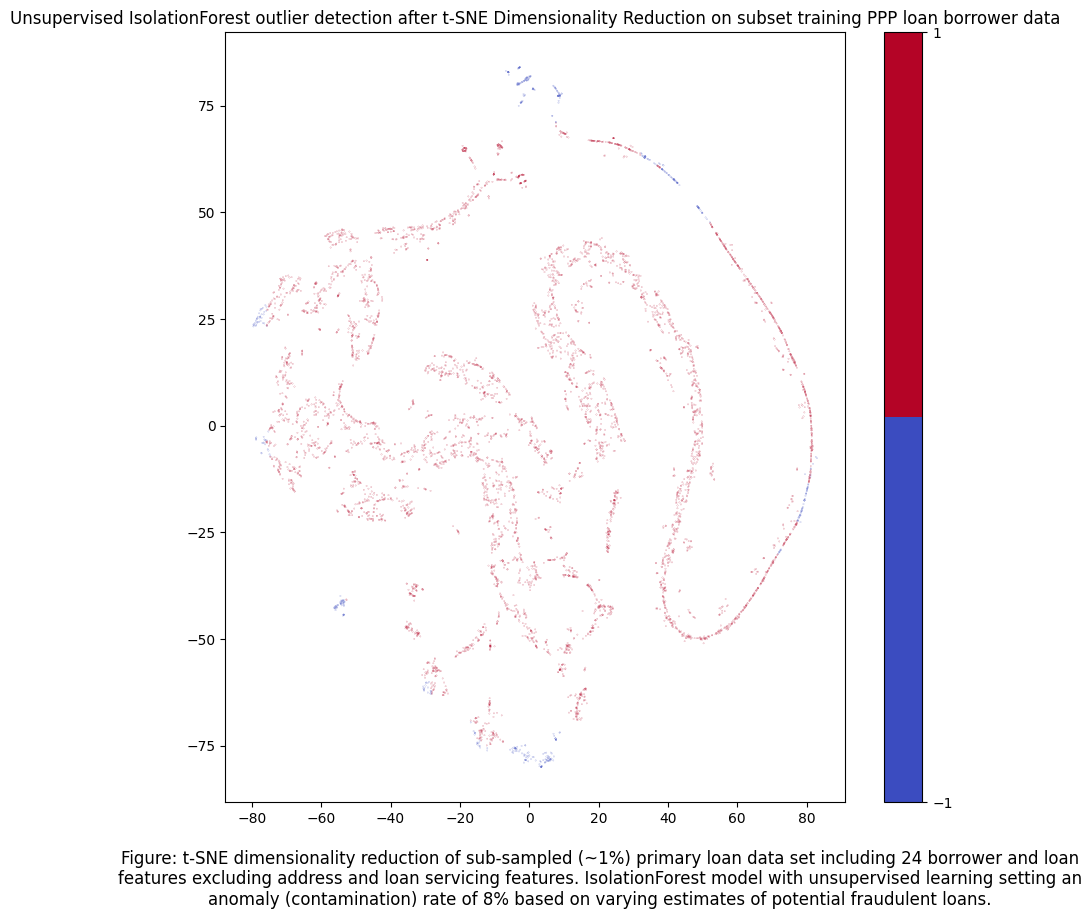

In [24]:
fig, ax = plt.subplots(figsize = [10,10])
ax.set_title('Unsupervised IsolationForest outlier detection after t-SNE Dimensionality Reduction on subset training PPP loan borrower data')

cmap = plt.get_cmap('coolwarm', 2)

plt.scatter(loan_tsne[:, 0], loan_tsne[:, 1], c=pred_iforest_tsne, s=0.01, cmap=cmap)

plt.colorbar(ticks=[-1,1])
text = 'Figure: t-SNE dimensionality reduction of downsampled training loan data set including 30 borrower and loan features . IsolationForest model with unsupervised learning setting an anomaly (contamination) rate of 8% based on varying estimates of potential fraudulent loans.'

plt.figtext(0.5, 0.01, text, wrap=True, horizontalalignment='center', fontsize=12)

In [ ]:
pred_scores = -1*i_forest.score_samples(loan_tsne)

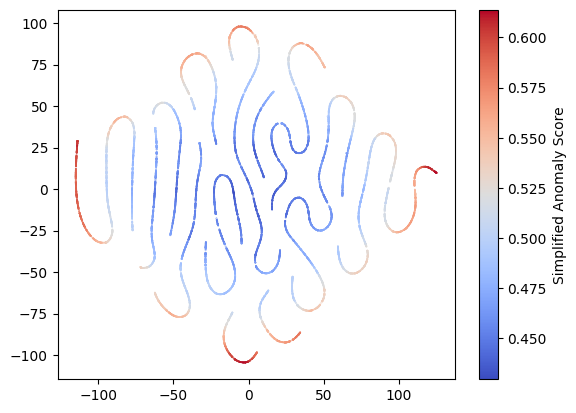

In [ ]:
plt.scatter(loan_tsne[:, 0], loan_tsne[:, 1], c=pred_scores, s=0.1, cmap='coolwarm')
plt.colorbar(label='Simplified Anomaly Score')
plt.show()

## PCA

In [8]:
# Apply PCA
pca = PCA(n_components=2)
clf_pca = pca.fit_transform(df_model_data)

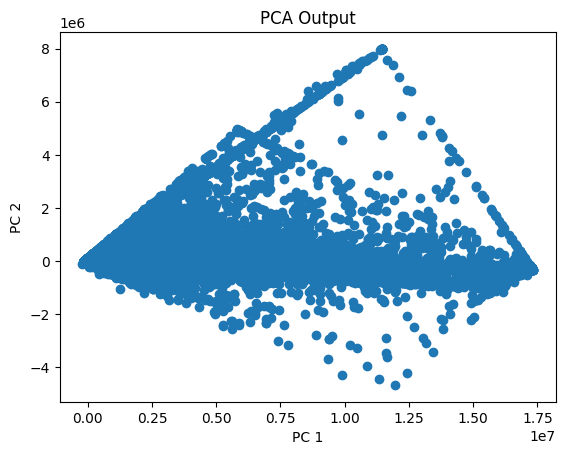

In [9]:
# Visualize PCA output
plt.scatter(clf_pca[:,0], clf_pca[:,1])
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.title('PCA Output')
plt.show()

In [ ]:
i_forest_pca = IsolationForest(n_estimators=200, contamination=contamination, verbose=2)

i_forest_pca.fit(loan_pca)


Building estimator 1 of 200 for this parallel run (total 200)...
Building estimator 2 of 200 for this parallel run (total 200)...
Building estimator 3 of 200 for this parallel run (total 200)...
Building estimator 4 of 200 for this parallel run (total 200)...
Building estimator 5 of 200 for this parallel run (total 200)...
Building estimator 6 of 200 for this parallel run (total 200)...
Building estimator 7 of 200 for this parallel run (total 200)...
Building estimator 8 of 200 for this parallel run (total 200)...
Building estimator 9 of 200 for this parallel run (total 200)...
Building estimator 10 of 200 for this parallel run (total 200)...
Building estimator 11 of 200 for this parallel run (total 200)...
Building estimator 12 of 200 for this parallel run (total 200)...
Building estimator 13 of 200 for this parallel run (total 200)...
Building estimator 14 of 200 for this parallel run (total 200)...
Building estimator 15 of 200 for this parallel run (total 200)...
Building estimator 

IsolationForest(contamination=0.01, n_estimators=200, verbose=2)

In [ ]:
pred_pca = i_forest.predict(loan_pca)

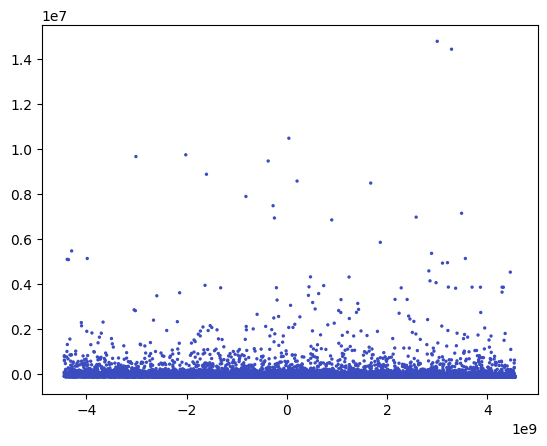

In [ ]:
plt.scatter(loan_pca[:, 0], loan_pca[:, 1], c=pred_pca, s=2, cmap='coolwarm')

In [ ]:
pred_scores_pca = -1*i_forest.score_samples(loan_pca)

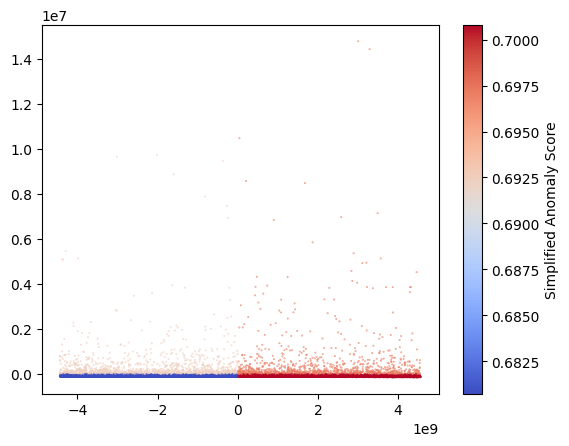

In [ ]:
plt.scatter(loan_pca[:, 0], loan_pca[:, 1], c=pred_scores_pca, s=0.1, cmap='coolwarm')
plt.colorbar(label='Simplified Anomaly Score')
plt.show()

# COPOD Anomoly Detection

In [7]:
# COPOD (Copula Based Outlier Detector) using Train/Test model data
clf_copod = COPOD(contamination = contamination, n_jobs = n_jobs)
clf_copod.fit(X_train)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.2s remaining:    9.7s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.4s finished


COPOD(contamination=0.08, n_jobs=-1)

In [8]:
pred_copod = clf_copod.predict(X_test)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


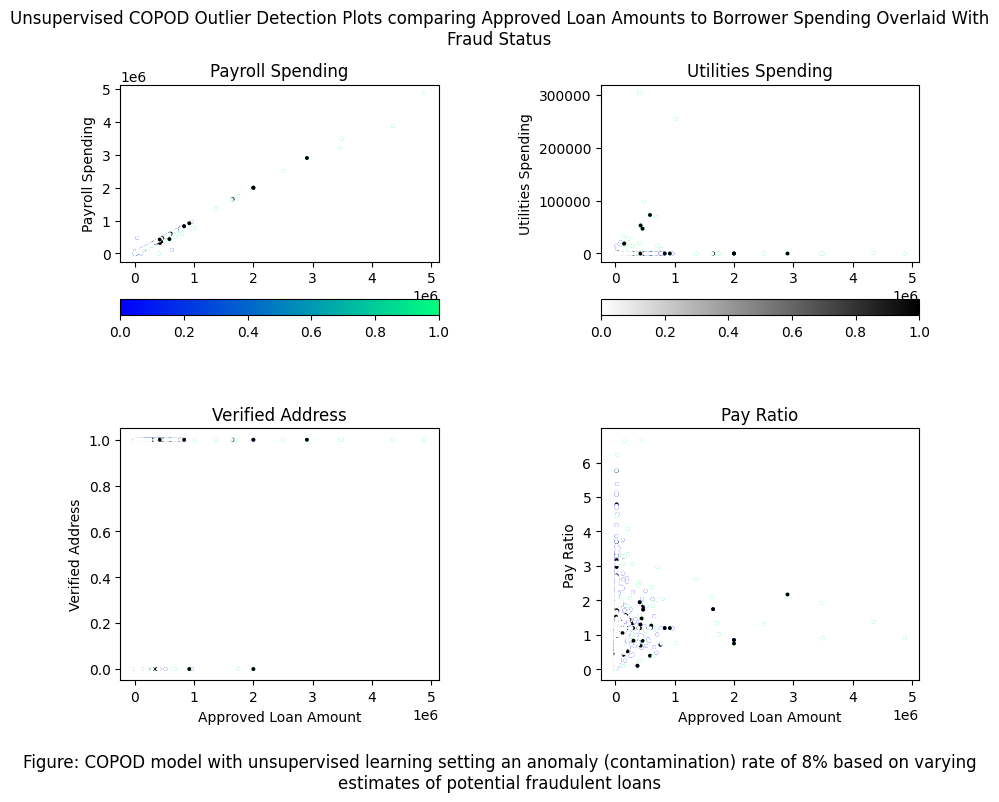

In [14]:
x = X_test['InitialApprovalAmount']
y1 = X_test['PAYROLL_PROCEED']
y2 = X_test['UTILITIES_PROCEED']
y3 = X_test['Verified_Address_cat']
y4 = X_test['pay_ratio']

labels = ['PAYROLL_PROCEED', 'UTILITIES_PROCEED', 'Verified_Address', 'pay_ratio']

cmap = 'winter'
cmap1 = 'binary'

fig, ax = plt.subplots(nrows=2, ncols=2, figsize = [10,8])

a0 = ax[0, 0].scatter(x, y1, c=pred_copod, s=3, cmap=cmap)
a1 = ax[0, 0].scatter(x, y1, c=y_test['Labelled_Loan_Binary'], s=3, cmap=cmap1)
a2 = ax[0, 1].scatter(x, y2, c=pred_copod, s=3, cmap=cmap)
a3 = ax[0, 1].scatter(x, y2, c=y_test['Labelled_Loan_Binary'], s=3, cmap=cmap1)
a4 = ax[1, 0].scatter(x, y3, c=pred_copod, s=3, cmap=cmap)
a5 = ax[1, 0].scatter(x, y3, c=y_test['Labelled_Loan_Binary'], s=3, cmap=cmap1)
a6 = ax[1, 1].scatter(x, y4, c=pred_copod, s=3, cmap=cmap)
a7 = ax[1, 1].scatter(x, y4, c=y_test['Labelled_Loan_Binary'], s=3, cmap=cmap1)


ax[0, 0].set_title('Payroll Spending')
ax[0, 1].set_title('Utilities Spending')
ax[1, 0].set_title('Verified Address')
ax[1, 1].set_title('Pay Ratio')

ax[0, 0].set_ylabel('Payroll Spending')
ax[0, 1].set_ylabel('Utilities Spending')
ax[1, 0].set_ylabel('Verified Address')
ax[1, 1].set_ylabel('Pay Ratio')

ax[1, 0].set_xlabel('Approved Loan Amount')
ax[1, 1].set_xlabel('Approved Loan Amount')

cbar0 = fig.colorbar(a0, location='bottom')
cbar1 = fig.colorbar(a3, location='bottom')

fig.tight_layout(pad=5.0)
fig.suptitle('Unsupervised COPOD Outlier Detection Plots comparing Approved Loan Amounts to Borrower Spending Overlaid With Fraud Status', wrap=True, horizontalalignment='center')

text = 'Figure: COPOD model with unsupervised learning setting an anomaly (contamination) rate of 8% based on varying estimates of potential fraudulent loans'

plt.figtext(0.5, 0.01, text, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

# Isolation Forest without Dimensionality Reduction

In [10]:
# IsolationForest model to produce overlaid plots with true labels and example EDA approaches
clf_name = 'IsolationForest'
clf = IsolationForest(n_estimators=100, contamination=contamination, verbose=2, n_jobs = n_jobs)
clf.fit(df_model_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


Building estimator 1 of 13 for this parallel run (total 100)...
Building estimator 1 of 13 for this parallel run (total 100)...
Building estimator 1 of 13 for this parallel run (total 100)...
Building estimator 1 of 13 for this parallel run (total 100)...
Building estimator 1 of 12 for this parallel run (total 100)...
Building estimator 1 of 12 for this parallel run (total 100)...
Building estimator 1 of 12 for this parallel run (total 100)...
Building estimator 1 of 12 for this parallel run (total 100)...
Building estimator 2 of 12 for this parallel run (total 100)...
Building estimator 2 of 13 for this parallel run (total 100)...
Building estimator 2 of 13 for this parallel run (total 100)...
Building estimator 2 of 13 for this parallel run (total 100)...
Building estimator 2 of 12 for this parallel run (total 100)...
Building estimator 2 of 12 for this parallel run (total 100)...
Building estimator 2 of 13 for this parallel run (total 100)...
Building estimator 2 of 12 for this para

[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    3.8s remaining:    6.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.9s finished
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


IsolationForest(contamination=0.08, n_jobs=-1, verbose=2)

In [12]:
pred_labels = clf.predict(df_model_data)

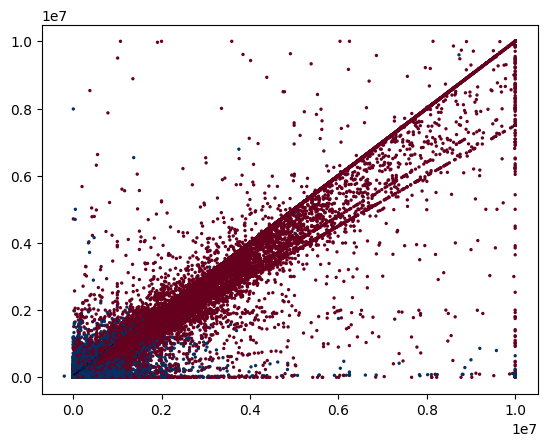

In [13]:
plt.scatter(df_model_data['InitialApprovalAmount'], df_model_data['PAYROLL_PROCEED'], c=pred_labels, s=2, cmap='RdBu')

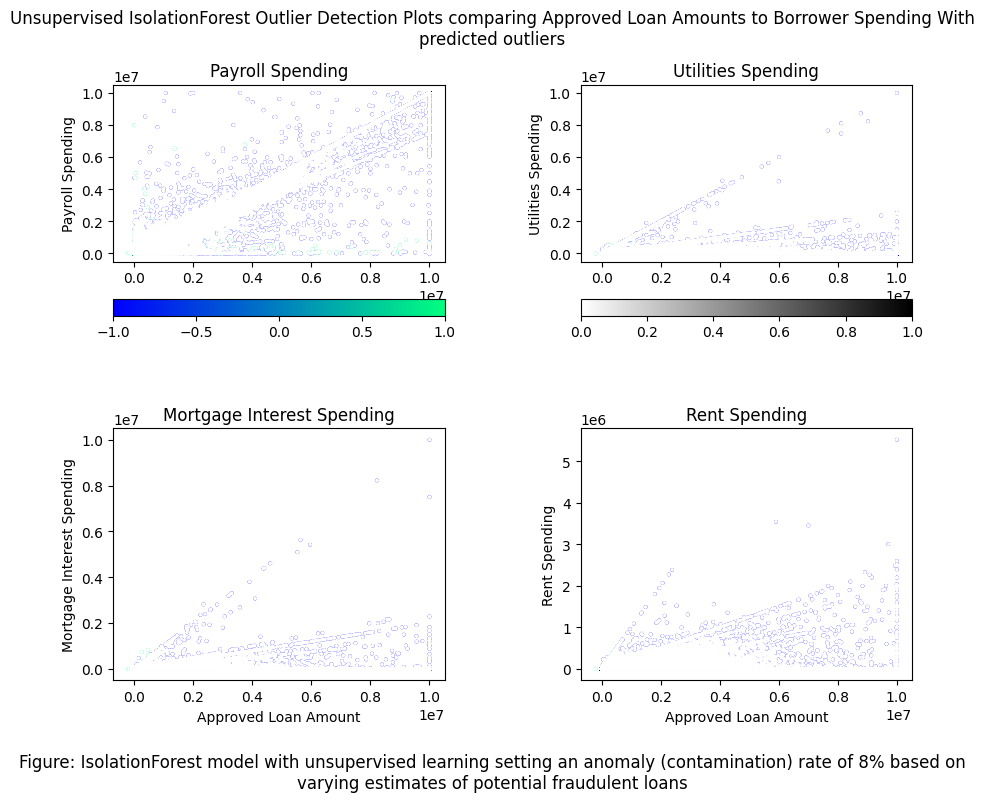

In [15]:
# Running IsolationForest predicted outliers with 8% anomaly rate based on
# selection from published literature review overlaid over the full
# model data and positive labels for prosecuted cases.

x = df_model_data['InitialApprovalAmount']
y1 = df_model_data['PAYROLL_PROCEED']
y2 = df_model_data['UTILITIES_PROCEED']
y3 = df_model_data['MORTGAGE_INTEREST_PROCEED']
y4 = df_model_data['RENT_PROCEED']

labels = ['PAYROLL_PROCEED', 'UTILITIES_PROCEED', 'MORTGAGE_INTEREST_PROCEED', 'RENT_PROCEED']

cmap = 'winter'
cmap1 = 'binary'

fig, ax = plt.subplots(nrows=2, ncols=2, figsize = [10,8])

a0 = ax[0, 0].scatter(x, y1, c=pred_labels, s=3, cmap=cmap)
a1 = ax[0, 0].scatter(x, y1, c=df_model_data.CaseLabel_cat, s=3, cmap=cmap1)
a2 = ax[0, 1].scatter(x, y2, c=pred_labels, s=3, cmap=cmap)
a3 = ax[0, 1].scatter(x, y2, c=df_model_data.CaseLabel_cat, s=3, cmap=cmap1)
a4 = ax[1, 0].scatter(x, y3, c=pred_labels, s=3, cmap=cmap)
a5 = ax[1, 0].scatter(x, y3, c=df_model_data.CaseLabel_cat, s=3, cmap=cmap1)
a6 = ax[1, 1].scatter(x, y4, c=pred_labels, s=3, cmap=cmap)
a7 = ax[1, 1].scatter(x, y4, c=df_model_data.CaseLabel_cat, s=3, cmap=cmap1)

ax[0, 0].set_title('Payroll Spending')
ax[0, 1].set_title('Utilities Spending')
ax[1, 0].set_title('Mortgage Interest Spending')
ax[1, 1].set_title('Rent Spending')

ax[0, 0].set_ylabel('Payroll Spending')
ax[0, 1].set_ylabel('Utilities Spending')
ax[1, 0].set_ylabel('Mortgage Interest Spending')
ax[1, 1].set_ylabel('Rent Spending')

ax[1, 0].set_xlabel('Approved Loan Amount')
ax[1, 1].set_xlabel('Approved Loan Amount')

cbar0 = fig.colorbar(a0, location='bottom')
cbar1 = fig.colorbar(a3, location='bottom')

fig.tight_layout(pad=5.0)
fig.suptitle('Unsupervised IsolationForest Outlier Detection Plots comparing Approved Loan Amounts to Borrower Spending With predicted outliers', wrap=True, horizontalalignment='center')

text = 'Figure: IsolationForest model with unsupervised learning setting an anomaly (contamination) rate of 8% based on varying estimates of potential fraudulent loans'

plt.figtext(0.5, 0.01, text, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

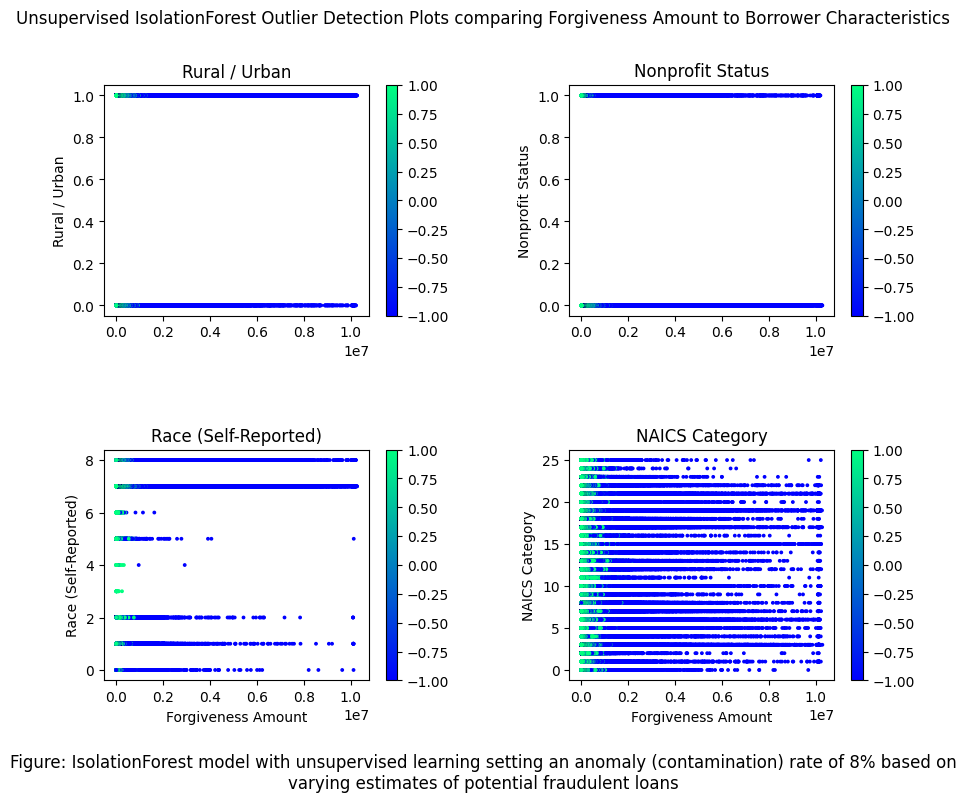

In [17]:
x = df_model_data['ForgivenessAmount']
y1 = df_model_data['RuralUrbanIndicator_cat']
y2 = df_model_data['NonProfit_cat']
y3 = df_model_data['Race_cat']
y4 = df_model_data['NAICSCode_2digits_cat']

cmap = 'winter'

fig, ax = plt.subplots(nrows=2, ncols=2, figsize = [10,8])
a0 = ax[0, 0].scatter(x, y1, c=pred_labels, s=3, cmap=cmap)
a1 = ax[0, 1].scatter(x, y2, c=pred_labels, s=3, cmap=cmap)
a2 = ax[1, 0].scatter(x, y3, c=pred_labels, s=3, cmap=cmap)
a3 = ax[1, 1].scatter(x, y4, c=pred_labels, s=3, cmap=cmap)

ax[0, 0].set_title('Rural / Urban')
ax[0, 1].set_title('Nonprofit Status')
ax[1, 0].set_title('Race (Self-Reported)')
ax[1, 1].set_title('NAICS Category')

ax[0, 0].set_ylabel('Rural / Urban')
ax[0, 1].set_ylabel('Nonprofit Status')
ax[1, 0].set_ylabel('Race (Self-Reported)')
ax[1, 1].set_ylabel('NAICS Category')

ax[1, 0].set_xlabel('Forgiveness Amount')
ax[1, 1].set_xlabel('Forgiveness Amount')

cbar0 = fig.colorbar(a0, ax=ax[0][0])
cbar1 = fig.colorbar(a1, ax=ax[0][1])
cbar2 = fig.colorbar(a2, ax=ax[1][0])
cbar3 = fig.colorbar(a3, ax=ax[1][1])

fig.tight_layout(pad=5.0)
fig.suptitle('Unsupervised IsolationForest Outlier Detection Plots comparing Forgiveness Amount to Borrower Characteristics', wrap=True, horizontalalignment='center')

text = 'Figure: IsolationForest model with unsupervised learning setting an anomaly (contamination) rate of 8% based on varying estimates of potential fraudulent loans'

plt.figtext(0.5, 0.01, text, wrap=True, horizontalalignment='center', fontsize=12)
plt.show()